# DATA ENGINEERING: Stock Prediction

* HCMUT-VNU
* Semester: 231
* Group 17

# 0. Description

# 1. Data fields

There are some data fields that VN30 provided. They are described as below:

+ Ngày: Gồm ngày tháng năm cụ thể.

+ Lần cuối: Hay còn gọi là "Giá đóng"(close price), có nghĩa là giá cổ phiếu của phiên giao dịch cuối của ngày đó.

+ Mở: Hay còn gọi là "Giá mở"(open price), có nghĩa là giá cổ phiếu của phiên giao dịch đầu của ngày đó.

+ Cao: Hay còn gọi là "Giá trần", có nghĩa là giá cổ phiếu cao nhất trong ngày.

+ Thấp: Hay còn gọi là "Giá sàn", có nghĩa là giá cổ phiếu thấp nhất trong ngày.

+ KL: Số lượng giao dịch trong ngày của cổ phiếu.

+ % Thay đổi: Phần trăm thay đổi của giá đóng của ngày hôm sau so với ngày hiện tại.


Also, there are some fields that we can derive:

## RSI 
- Đây là "Chỉ số sức mạnh tương đối"(Relevant Strength Index) là giá trị phản ánh tình trạng quá "mua" hoặc quá "bán" trên thị trường. Có công thức như sau:

$$RSI=100-[\dfrac{100}{1+\dfrac{\text{Mức tăng trung bình}}{\text{Tổn thất trung bình}}}]$$

- Giá trị của RSI được biểu diễn trong khoảng từ 0 đến 100. Thông thường:

    + Nếu RSI > 70, thì cổ phiếu đang bị mua quá mức dẫn đến việc xu hướng tăng của giá trị cổ phiếu có khả năng bị giảm và xu hướng giảm có khả năng tăng.

    + Nếu RSI < 30, thì cổ phiếu đang bị bán quá mức dẫn đến giá trị cổ phiếu gần chạm đáy và chuẩn bị tăng.
    
    + Nếu RSI giữa khoảng (30,70) được coi là trung tính. Ví dụ với mức RSI=50 thì xem là không có xu hướng.

- Bên cạnh việc thể hiện tình trạng quá bán hoặc quá mua, nhà đầu tư cũng có thể sử dụng phân kỳ RSI để dự đoán xu hướng đảo chiều. Sự phân kỳ xảy ra khi giá chứng khoán di chuyển theo hướng ngược lại so với các chỉ báo kỹ thuật. Điều này cảnh báo xu hướng giá hiện tại có thể đang suy yếu và nguy cơ dẫn đến sự thay đổi hướng của giá. Trong đó có hai loại là phân kỳ âm và phân kỳ dương:

    + Phân kỳ dương: RSI tăng tạo đáy cao trong khi giá giảm tạo đáy thấp, cảnh báo đà tăng mạnh bất chấp xu hướng giá giảm.

    + Phân kỳ âm: RSI giảm và tạo đỉnh thấp trong khi giá tài sản tăng tạo đỉnh cao hơn, cảnh báo giá có thể giảm mạnh.


## EMA

- Đây là "Đường trung bình động luỹ thừa"(Exponent Moving Average). Nó được dùng để phản ánh sự biến động giá được tính theo cấp số nhân, qua đó giúp nhà đầu tư xác định được sự biến động giá một cách chuẩn xác hơn và giảm thiểu được tình trạng nhiễu giá so với đường trung bình động thông thường. 

- Có công thức:

$$\text{EMA}(t)=P(t) \times K + \text{EMA}(t-1) \times (1-K)$$

- Với:

    + $P(t)$: giá đóng của cổ phiếu ở ngày t.
 
    + $K=\dfrac{2}{1+N}$: hệ số làm trơn, được tính bằng công thức đính kèm với N là chu kì (ví dụ như 5 ngày, 10 ngày,...).
 
    + EMA(t): giá trị EMA tại ngày t.

- Sự di chuyển của đường EMA phản ánh xu hướng dịch chuyển của giá, thông qua đó nhà đầu tư nắm bắt tình hình xu hướng giá ngay thời điểm hiện tại.

- Đường EMA dốc lên thể hiện giá đang đi lên, thị trường trong xu hướng tăng. Ngược lại, đường EMA dốc xuống thể hiện giá đang đi xuống, thị trường trong xu hướng giảm. Đường EMA nằm ngang đồng nghĩa với giá cũng đi ngang, thị trường trong trạng thái sideway.

- EMA được theo 3 khung thời gian gồm có:

    + EMAF: EMA nhanh, thường tương ứng với các chu kỳ nhỏ.
    
    + EMAM: EMA trung bình, thường tương ứng với các chu kỳ trung bình.
    + EMAS: EMA chậm, thường tương ứng với chu kỳ lớn.

- Dựa vào sự cắt nhau của các đường EMAF, EMAM, EMAS và đường giá, ta sẽ xác định được xu hướng tăng hoặc giảm của cổ phiếu đó.

# 2. Data processing

### Import Libraries

In [64]:
# !pip3 install numpy matplotlib yfinance
# !pip3 install -U git+https://github.com/twopirllc/pandas-ta.git@development
# !pip3 install seaborn

In [65]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import seaborn as sns

### Import VN30 data

In [66]:
data = pd.read_csv('VN30_031023-031013.csv') # there are no null values in this CSV file
data.head(5)

,Date,Close,Open,High,Low,Vol,Percentage Change
0,03/10/2023,"1,130.89","1,156.86","1,158.38","1,128.54",260.26K,-3.11%
1,02/10/2023,"1,167.13","1,166.64","1,173.06","1,159.16",119.87K,0.07%
2,29/09/2023,"1,166.26","1,169.26","1,176.77","1,165.15",144.90K,0.16%
3,28/09/2023,"1,164.45","1,167.96","1,168.09","1,144.47",193.65K,-0.36%
4,27/09/2023,"1,168.60","1,154.54","1,168.60","1,141.09",190.47K,1.32%


### As we can see, our VN30 data is being reversed

In [67]:
data = data.iloc[::-1]
data.reset_index(drop=True, inplace=True)
data

,Date,Close,Open,High,Low,Vol,Percentage Change
0,03/10/2013,549.58,552.41,552.66,548.44,19.12K,-0.57%
1,04/10/2013,552.07,549.74,552.27,548.63,17.85K,0.45%
2,07/10/2013,557.54,552.55,557.95,552.30,22.80K,0.99%
3,08/10/2013,558.55,557.83,560.36,555.02,29.15K,0.18%
4,09/10/2013,556.72,558.24,558.99,555.25,17.70K,-0.33%
...,...,...,...,...,...,...,...
2491,27/09/2023,"1,168.60","1,154.54","1,168.60","1,141.09",190.47K,1.32%
2492,28/09/2023,"1,164.45","1,167.96","1,168.09","1,144.47",193.65K,-0.36%
2493,29/09/2023,"1,166.26","1,169.26","1,176.77","1,165.15",144.90K,0.16%
2494,02/10/2023,"1,167.13","1,166.64","1,173.06","1,159.16",119.87K,0.07%


### Get data types:

In [68]:
data.dtypes

Date                 object
Close                object
Open                 object
High                 object
Low                  object
Vol                  object
Percentage Change    object
dtype: object

As we can see, **Open**, **Close**, **High**, **Low** price got the same string format, but how about **Vol** ?

In [69]:
data['Vol'].str[-1].value_counts()

Vol
K    2491
M       5
Name: count, dtype: int64

There are 2 different values in **Vol**.

Convert data types:

In [70]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')


data['Close'] = pd.to_numeric(data['Close'].str.replace(',',''))
data['Open'] = pd.to_numeric(data['Open'].str.replace(',',''))
data['High'] = pd.to_numeric(data['High'].str.replace(',',''))
data['Low'] = pd.to_numeric(data['Low'].str.replace(',',''))

data['Percentage Change'] = data['Percentage Change'].str.replace('%', '')
data['Percentage Change'] = pd.to_numeric(data['Percentage Change']) # if null then NaN

# data.head()

* Volume:
    - K: Increase 1000 times.
    - M: Increase 1000_000 times.

In [71]:
for i in range(len(data['Vol'])):
    if data['Vol'].loc[i][-1] == 'K':
        data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
        # print(data['Vol'].loc[i] )
        data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
    else: 
        data['Vol'].loc[i] = data['Vol'].loc[i].replace('M','')
        data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000000)

/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_92868/1638476980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [72]:
data['Vol'] = data['Vol'].astype(int)
data.head(5)

,Date,Close,Open,High,Low,Vol,Percentage Change
0,2013-10-03,549.58,552.41,552.66,548.44,19120,-0.57
1,2013-10-04,552.07,549.74,552.27,548.63,17850,0.45
2,2013-10-07,557.54,552.55,557.95,552.30,22800,0.99
3,2013-10-08,558.55,557.83,560.36,555.02,29150,0.18
4,2013-10-09,556.72,558.24,558.99,555.25,17700,-0.33


In [73]:
data.dtypes

Date                 datetime64[ns]
Close                       float64
Open                        float64
High                        float64
Low                         float64
Vol                           int64
Percentage Change           float64
dtype: object

### Number of record of each year from 03/10/2013 to 203/10/2023:

In [74]:
for i in range (2013,2024):
    print(i,data[data['Date'].dt.year==i].size)

2013 448
2014 1729
2015 1736
2016 1757
2017 1750
2018 1743
2019 1750
2020 1764
2021 1750
2022 1743
2023 1302


In [75]:
data.head()

,Date,Close,Open,High,Low,Vol,Percentage Change
0,2013-10-03,549.58,552.41,552.66,548.44,19120,-0.57
1,2013-10-04,552.07,549.74,552.27,548.63,17850,0.45
2,2013-10-07,557.54,552.55,557.95,552.30,22800,0.99
3,2013-10-08,558.55,557.83,560.36,555.02,29150,0.18
4,2013-10-09,556.72,558.24,558.99,555.25,17700,-0.33


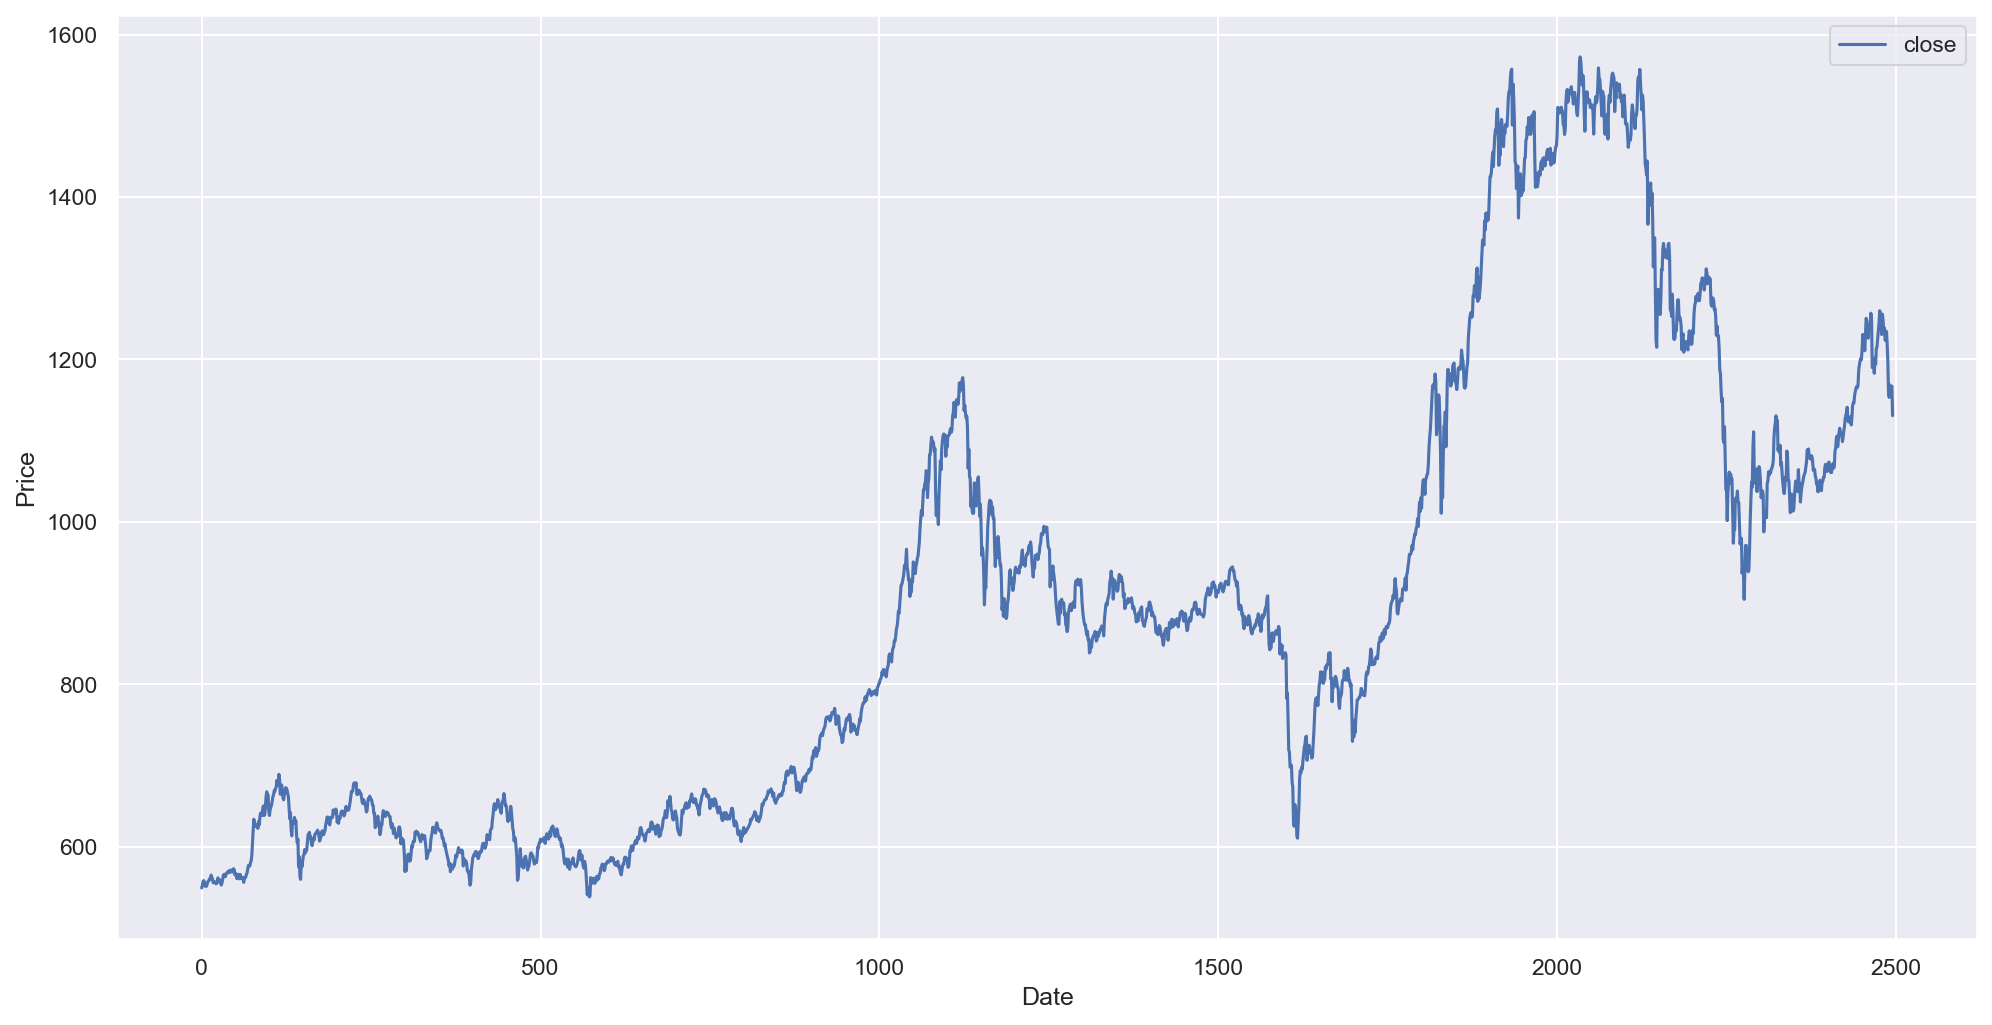

In [76]:
plt.figure(figsize=(16, 8), dpi=150) 

data['Close'].plot(x=data['Date'],label='close')
# data['High'].plot(x=data['Date'],label='high')
# data['Low'].plot(x=data['Date'],label='low')

# data['Open'].plot(label='open')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend() 

### Number of trade for each day (of week):

In [77]:
data['dayofweek'] = data['Date'].dt.dayofweek
data.groupby('dayofweek').agg({'Vol':['sum']})

,Vol
,sum
dayofweek,
0,75548605
1,81016394
2,72851016
3,73431784
4,69654354


As we can see, there are no Saturday and Sunday but there are lots of trade on Monday and Friday. 

### Add indicators

* RSI:

Choose t period:

In [78]:
for i in range(5,21):
    df = data.copy()
    df['RSI'] = ta.rsi(df.Close, length=i)
    df.dropna(inplace=True)
    print(i,':',df['RSI'].corr(data['Close']))

5 : 0.030753081691752542
6 : 0.032020993706694215
7 : 0.033073507407670066
8 : 0.033976963455208016
9 : 0.03474006362265739
10 : 0.035353352795538286
11 : 0.03580749273764777
12 : 0.03609928131412639
13 : 0.03623212186602929
14 : 0.036214528255693046
15 : 0.03605827356301644
16 : 0.03577678861366704
17 : 0.03538396834057648
18 : 0.03489336609940319
19 : 0.03431769940973615
20 : 0.03366858415289855


    RSI with 15 days period.

In [79]:
# RSI
data['RSI'] = ta.rsi(data.Close, length=14)

* EMA:

    - EMAF: 20 days
    - EMAM: 50 days
    - EMAS: 100 days

In [80]:
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=50)
data['EMAS'] = ta.ema(data.Close, length=100)

* VWAP:

In [81]:
data['average'] = (data['High'] + data['Low'] + data['Close'])/3
data['average']

0        550.226667
1        550.990000
2        555.930000
3        557.976667
4        556.986667
           ...     
2491    1159.430000
2492    1159.003333
2493    1169.393333
2494    1166.450000
2495    1139.270000
Name: average, Length: 2496, dtype: float64

In [82]:
data['vwap'] = (data['average'] * data['Vol'])/ data['Vol']
data['vwap']

0        550.226667
1        550.990000
2        555.930000
3        557.976667
4        556.986667
           ...     
2491    1159.430000
2492    1159.003333
2493    1169.393333
2494    1166.450000
2495    1139.270000
Name: vwap, Length: 2496, dtype: float64

Percentage change of vwap:

In [83]:
data['vwap_pct_ret'] = data['vwap'].pct_change()
data['vwap_pct_ret']

0            NaN
1       0.001387
2       0.008966
3       0.003682
4      -0.001774
          ...   
2491   -0.000506
2492   -0.000368
2493    0.008965
2494   -0.002517
2495   -0.023301
Name: vwap_pct_ret, Length: 2496, dtype: float64

In [84]:
data['pvwap'] = data['vwap_pct_ret'].shift(-1)
data['pvwap']

0       0.001387
1       0.008966
2       0.003682
3      -0.001774
4      -0.005853
          ...   
2491   -0.000368
2492    0.008965
2493   -0.002517
2494   -0.023301
2495         NaN
Name: pvwap, Length: 2496, dtype: float64

* Target:

In [85]:
'''
Target: Boolean value, 0 if the next closing price smaller than the current closing price.
'''
data['Target'] = (data['Close'] - data.Open).shift(-1) 

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)


data.head()

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Vol', 'Date', "Percentage Change", "index",'average'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close            2396 non-null   float64
 1   Open             2396 non-null   float64
 2   High             2396 non-null   float64
 3   Low              2396 non-null   float64
 4   dayofweek        2396 non-null   int32  
 5   RSI              2396 non-null   float64
 6   EMAF             2396 non-null   float64
 7   EMAM             2396 non-null   float64
 8   EMAS             2396 non-null   float64
 9   vwap             2396 non-null   float64
 10  vwap_pct_ret     2396 non-null   float64
 11  pvwap            2396 non-null   float64
 12  Target           2396 non-null   float64
 13  TargetClass      2396 non-null   int64  
 14  TargetNextClose  2396 non-null   float64
dtypes: float64(13), int32(1), int64(1)
memory usage: 271.6 KB


In [86]:
pd.set_option('display.max_columns', None)

data.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Close,Open,High,Low,dayofweek,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose
0,643.95,663.17,663.48,643.95,0,56.423040,640.718510,614.236538,582.110100,650.460000,-0.019131,-0.019868,1.86,1,638.79
1,638.79,636.93,641.89,631.93,1,53.146950,640.534842,615.199419,583.232474,637.536667,-0.019868,0.012371,-0.47,0,645.76
2,645.76,646.23,647.85,642.66,2,56.796087,641.032476,616.397873,584.470643,645.423333,0.012371,0.004333,2.23,1,648.62
3,648.62,646.39,650.74,645.30,3,58.233554,641.755097,617.661486,585.740927,648.220000,0.004333,0.005703,0.53,1,651.46
4,651.46,650.93,654.20,650.09,4,59.668565,642.679374,618.986918,587.042295,651.916667,0.005703,0.004448,3.26,1,655.80
5,655.80,652.54,656.87,651.78,0,61.827006,643.928957,620.430568,588.403834,654.816667,0.004448,0.006979,4.68,1,661.61
6,661.61,656.93,662.85,653.70,1,64.561301,645.612866,622.045448,589.853461,659.386667,0.006979,0.010955,-2.08,0,663.84
7,663.84,665.92,672.15,663.84,2,65.580382,647.348784,623.684450,591.318541,666.610000,0.010955,0.000270,5.11,1,669.21
8,669.21,664.10,669.21,661.95,3,67.969044,649.430804,625.469766,592.860946,666.790000,0.000270,0.003849,-1.31,0,668.39
9,668.39,669.70,673.91,665.77,4,67.202114,651.236442,627.152912,594.356571,669.356667,0.003849,0.003695,-0.39,0,672.15


### RSI Distribution

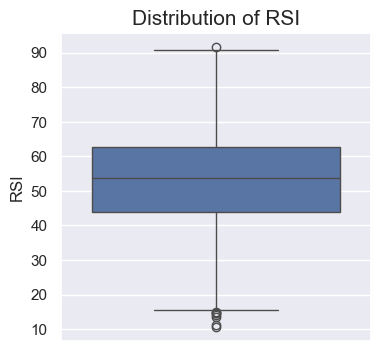

In [87]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(4,4)})    
sns.boxplot( y="RSI", data=data)
plt.ylabel('RSI', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of RSI", fontsize=15)
plt.show()

### Scale data by Scikit StandardScaler

In [88]:
# !pip3 install scikit-learn

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
data_set = scaler.fit_transform(data)

In [91]:
print(data_set)

[[-0.94268362 -0.87385176 -0.88840026 ...  0.16668657  0.95990176
  -0.96182459]
 [-0.96104805 -0.96716806 -0.96458289 ... -0.03438947 -1.04177328
  -0.937017  ]
 [-0.93624184 -0.93409483 -0.94355239 ...  0.1986171   0.95990176
  -0.92683771]
 ...
 [ 0.90977472  0.92131342  0.89217039 ... -0.25272524 -1.04177328
   0.91554389]
 [ 0.9162165   0.92593656  0.9227987  ...  0.04845731  0.95990176
   0.91864039]
 [ 0.91931283  0.91661916  0.90970757 ... -2.23500699 -1.04177328
   0.78965517]]


### Create Data for training and testing

* X: Input set
* Y: Output set

In [92]:
X = []
# print(data_set[0].size) # => 11
backcandles = 10
# print(data_set.shape[0]) # => 2346

# get all columns except "Target",	"TargetClass",	"TargetNextClose"
for i in range(12):
    X.append([])
    for j in range(backcandles, data_set.shape[0]):
        X[i].append(data_set[j-backcandles:j,i]) # get each "backcandles" element from each column.

print("0:",X[0][0:1]) # first candle set of Close Price
print("1:",X[1][0:1]) # first candle set of Open Price


0: [array([-0.94268362, -0.96104805, -0.93624184, -0.9260631 , -0.91595555,
       -0.9005095 , -0.87983172, -0.87189516, -0.85278334, -0.85570172])]
1: [array([-0.87385176, -0.96716806, -0.93409483, -0.93352582, -0.9173804 ,
       -0.91165482, -0.89604283, -0.86407204, -0.87054444, -0.85062937])]


In [93]:
X = np.moveaxis(X,[0],[2]) # Transposition

In [94]:
X[0][:3]

array([[-0.94268362, -0.87385176, -0.88840026, -0.92684347, -1.42326297,
         0.2236607 , -0.95159243, -1.04225447, -1.15331435, -0.91933305,
        -1.91823497, -1.99013898],
       [-0.96104805, -0.96716806, -0.96458289, -0.97003817, -0.71444192,
        -0.01743697, -0.95224976, -1.03877713, -1.1491986 , -0.96534948,
        -1.99103766,  1.1933899 ],
       [-0.93624184, -0.93409483, -0.94355239, -0.93147917, -0.00562087,
         0.2511144 , -0.95046879, -1.03444905, -1.14465823, -0.93726723,
         1.19365375,  0.39969729]])

In [95]:
X_lstm = np.array(X)
y_lstm = np.reshape(np.array(data_set[backcandles:,-1]), (len(np.array(data_set[backcandles:,-1])),1))# LSTM got output from "backcandle"
# 1 col, with len(X)-backcandles rows

In [96]:
print("Shape",y_lstm.shape)
print(y_lstm)

Shape (2386, 1)
[[-0.83764429]
 [-0.80824534]
 [-0.82910222]
 ...
 [ 0.91554389]
 [ 0.91864039]
 [ 0.78965517]]


In [97]:
X_classification = data.to_numpy()[:,:12]
X_classification

array([[ 6.43950000e+02,  6.63170000e+02,  6.63480000e+02, ...,
         6.50460000e+02, -1.91310117e-02, -1.98679909e-02],
       [ 6.38790000e+02,  6.36930000e+02,  6.41890000e+02, ...,
         6.37536667e+02, -1.98679909e-02,  1.23705303e-02],
       [ 6.45760000e+02,  6.46230000e+02,  6.47850000e+02, ...,
         6.45423333e+02,  1.23705303e-02,  4.33307338e-03],
       ...,
       [ 1.16445000e+03,  1.16796000e+03,  1.16809000e+03, ...,
         1.15900333e+03, -3.67996918e-04,  8.96459889e-03],
       [ 1.16626000e+03,  1.16926000e+03,  1.17677000e+03, ...,
         1.16939333e+03,  8.96459889e-03, -2.51697461e-03],
       [ 1.16713000e+03,  1.16664000e+03,  1.17306000e+03, ...,
         1.16645000e+03, -2.51697461e-03, -2.33014703e-02]])

In [98]:
y_classification = np.where(data['TargetNextClose'] > data['Close'], 1, 0)
y_classification

array([0, 1, 1, ..., 1, 1, 0])

### Split data

In [99]:
splitlimit = int(len(X_lstm)*0.8)
print("Split lim:",splitlimit)

Split lim: 1908


* Classification models train/test set:

In [100]:
X_train_classification, X_test_classification = X_classification[:splitlimit], X_classification[splitlimit:]
y_train_classification, y_test_classification = y_classification[:splitlimit], y_classification[splitlimit:]
print("Xtrain shape",X_train_classification.shape)
print("Xtest shape",X_test_classification.shape)
print("ytrain",y_train_classification.shape)
print("ytest",y_test_classification.shape)
print("ytrain:\n",y_train_classification)
print("ytest:\n",y_test_classification)

Xtrain shape (1908, 12)
Xtest shape (488, 12)
ytrain (1908,)
ytest (488,)
ytrain:
 [0 1 1 ... 1 1 0]
ytest:
 [0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1
 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1
 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1
 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0
 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0
 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0
 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0
 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1

* LSTM train/test set:

In [101]:
X_train_lstm, X_test_lstm = X_lstm[:splitlimit], X_lstm[splitlimit:]
y_train_lstm, y_test_lstm = y_lstm[:splitlimit], y_lstm[splitlimit:]
print("Xtrain shape",X_train_lstm.shape)
print("Xtest shape",X_test_lstm.shape)
print("ytrain",y_train_lstm.shape)
print("ytest",y_test_lstm.shape)

Xtrain shape (1908, 10, 12)
Xtest shape (478, 10, 12)
ytrain (1908, 1)
ytest (478, 1)
ytrain:
 [[-0.83764429]
 [-0.80824534]
 [-0.82910222]
 ...
 [ 2.21852951]
 [ 2.16300608]
 [ 2.17937837]]
ytest:
 [[ 2.21247888]
 [ 2.20379445]
 [ 2.21642959]
 [ 2.23031045]
 [ 2.19995052]
 [ 2.18806281]
 [ 2.1544996 ]
 [ 2.20283346]
 [ 2.20546727]
 [ 2.1646789 ]
 [ 2.1730786 ]
 [ 2.11556201]
 [ 2.10356752]
 [ 2.16403824]
 [ 2.22127009]
 [ 2.33576939]
 [ 2.36128882]
 [ 2.34025398]
 [ 2.29216925]
 [ 2.23717969]
 [ 2.28067306]
 [ 2.24888945]
 [ 2.11755516]
 [ 2.03548013]
 [ 2.1483066 ]
 [ 2.16090615]
 [ 2.20877732]
 [ 2.17265149]
 [ 2.17742081]
 [ 2.16190272]
 [ 2.17250913]
 [ 2.13958657]
 [ 2.15165224]
 [ 2.15179461]
 [ 2.14424912]
 [ 2.11805344]
 [ 2.02284498]
 [ 2.12712939]
 [ 2.15517585]
 [ 2.18717301]
 [ 2.16012313]
 [ 2.17322096]
 [ 2.23048841]
 [ 2.31291936]
 [ 2.26714812]
 [ 2.26337537]
 [ 2.218138  ]
 [ 2.15570973]
 [ 2.10246417]
 [ 2.21030777]
 [ 2.19745908]
 [ 2.18727978]
 [ 2.02725839]
 [ 2.0

## Summary

In [102]:
# csv file from https://vn.investing.com/indices
def pre_process(filename):

    data = pd.read_csv(filename)

    data = data.iloc[::-1]
    data.reset_index(drop=True, inplace=True)

    data['Vol'].str[-1].value_counts()
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data['Close'] = pd.to_numeric(data['Close'].str.replace(',',''))
    data['Open'] = pd.to_numeric(data['Open'].str.replace(',',''))
    data['High'] = pd.to_numeric(data['High'].str.replace(',',''))
    data['Low'] = pd.to_numeric(data['Low'].str.replace(',',''))

    data['Percentage Change'] = data['Percentage Change'].str.replace('%', '')
    data['Percentage Change'] = pd.to_numeric(data['Percentage Change']) # if null then NaN

    for i in range(len(data['Vol'])):
        if data['Vol'].loc[i][-1] == 'K':
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
            # print(data['Vol'].loc[i] )
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
        else: 
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('M','')
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000000)

    data['Vol'] = data['Vol'].astype(int)
    data['dayofweek'] = data['Date'].dt.dayofweek
    data['RSI'] = ta.rsi(data.Close, length=14)
    data['EMAF'] = ta.ema(data.Close, length=20)
    data['EMAM'] = ta.ema(data.Close, length=50)
    data['EMAS'] = ta.ema(data.Close, length=100)
    data['average'] = (data['High'] + data['Low'] + data['Close'])/3
    data['vwap'] = (data['average'] * data['Vol'])/ data['Vol']
    data['vwap_pct_ret'] = data['vwap'].pct_change()
    data['pvwap'] = data['vwap_pct_ret'].shift(-1)

    # TARGETS ===========================
    data['Target'] = (data['Close'] - data.Open).shift(-1) 
    data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
    data['TargetNextClose'] = data['Close'].shift(-1)
    #  ===========================

    data.dropna(inplace=True)
    data.reset_index(inplace = True)
    data.drop(['Vol', 'Date', "Percentage Change", "index",'average'], axis=1, inplace=True)
    
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    return data

# 3. Models

# SVM

In [103]:
from sklearn.svm import SVC

In [104]:

# Support vector classifier 
cls = SVC().fit(X_train_classification, y_train_classification)

In [105]:
y_pred_svm = cls.predict(X_test_classification)

# LSTM 

## Background

Trong nhiều ứng dụng máy học, đặc biệt là trong xử lý dữ liệu chuỗi, việc duy trì và hiểu được mối quan hệ trong dữ liệu thời gian là quan trọng. Các mô hình truyền thống như mạng nơ-ron thuần (feedforward neural networks) thường không thể hiệu quả trong việc này do không giữ được thông tin liên tục qua thời gian.
 
LSTM là một dạng đặc biệt của mạng nơ-ron hồi quy (RNN - Recurrent Neural Network) được thiết kế để vượt qua vấn đề "mất mát thông tin" trong quá trình học dữ liệu thời gian.

### Forget Gate

LSTM sử dụng cổng quên để quyết định xem thông tin nào nên được giữ lại và thông tin nào nên bị loại bỏ từ bước thời gian trước đó.

$$\ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \$$

$$\ C_t = f_t \odot C_{t-1} \$$

### Input Gate

Cổng đầu vào quyết định thông tin mới nào sẽ được thêm vào trạng thái ẩn.

$$\ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \$$

$$ \tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) \$$

$$\ C_t = i_t \odot \tilde{C}_t \$$


### Output Gate

Cổng đầu ra quyết định thông tin nào sẽ được xuất ra từ trạng thái ẩn để làm đầu vào cho bước thời gian tiếp theo.

$$\ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \$$

$$\ h_t = o_t \odot \tanh(C_t) \$$

Trong các công thức trên:

- $\mathbf{f}_t$, $\mathbf{i}_t$, $\mathbf{o}_t$ là các vectơ cổng quên, đầu vào, và đầu ra tương ứng.
- $\sigma$  là hàm sigmoid, $\tanh$ là hàm tanh.
- $\mathbf{W}_f$, $\mathbf{W}_i$, $\mathbf{W}_o$, $\mathbf{W}_c$ là ma trận trọng số cho các cổng và trạng thái ẩn.
- $\mathbf{h}_{t-1}$, $\mathbf{x}_t$ là vector kết hợp giữa trạng thái ẩn từ bước thời gian trước đó $\mathbf{h}_{t-1}$ và đầu vào $\mathbf{x}_t$.
- $\mathbf{b}_f$, $\mathbf{b}_i$, $\mathbf{b}_o$, $\mathbf{b}_c$ là các vectơ độ lệch (bias).

Các biến:

- $\mathbf{C}_t$ là trạng thái ẩn (cell state) tại thời điểm $t$.
- $\tilde{\mathbf{C}}_t$ là thông tin mới được đề xuất cho trạng thái ẩn.
- $\mathbf{h}_t$ là trạng thái ẩn đầu ra tại thời điểm $t$.
- $\odot$ đại diện cho phép nhân element-wise (tích vô hướng).

### Import Libraries

In [106]:
# !pip3 install keras tensorflow

In [107]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

### Layers

In [108]:
lstm_input = Input(shape=(backcandles, 12), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)  
inputs = Dense(1, name='dense_layer')(inputs)
output_relu = Activation('relu', name='output')(inputs)
lstm_model_relu = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
lstm_model.compile(optimizer=adam, loss='mse')
lstm_model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=20, epochs=40, shuffle=True, validation_split = 0.1)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 10, 12), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'") at layer "first_layer". The following previous layers were accessed without issue: []

In [ ]:
lstm_input = Input(shape=(backcandles, 12), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)  
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('', name='output')(inputs)
lstm_model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
lstm_model.compile(optimizer=adam, loss='mse')
lstm_model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=20, epochs=40, shuffle=True, validation_split = 0.1)

# 4. Model evaluation

## SVM

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(y_pred_svm, y_test_classification))

0.5102459016393442


In [ ]:
data_svm = data.copy()
data_svm['Predicted_Signal'] = cls.predict(X_classification)

* Calculate daily returns:

In [ ]:
data_svm['Return'] = data_svm.Close.pct_change()

* Calculate Strategy Returns:

In [ ]:
data_svm['Strategy_Return'] = data_svm.Return * data_svm.Predicted_Signal.shift(1)

* Calculate Cumulative Returns:

In [ ]:
data_svm['Cum_Ret'] = data_svm['Return'].cumsum() 
data_svm

,Close,Open,High,Low,dayofweek,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose,Predicted_Signal,Return,Strategy_Return,Cum_Ret
0,643.95,663.17,663.48,643.95,0,56.423040,640.718510,614.236538,582.110100,650.460000,-0.019131,-0.019868,1.86,1,638.79,1,NaN,NaN,NaN
1,638.79,636.93,641.89,631.93,1,53.146950,640.534842,615.199419,583.232474,637.536667,-0.019868,0.012371,-0.47,0,645.76,1,-0.008013,-0.008013,-0.008013
2,645.76,646.23,647.85,642.66,2,56.796087,641.032476,616.397873,584.470643,645.423333,0.012371,0.004333,2.23,1,648.62,1,0.010911,0.010911,0.002898
3,648.62,646.39,650.74,645.30,3,58.233554,641.755097,617.661486,585.740927,648.220000,0.004333,0.005703,0.53,1,651.46,1,0.004429,0.004429,0.007327
4,651.46,650.93,654.20,650.09,4,59.668565,642.679374,618.986918,587.042295,651.916667,0.005703,0.004448,3.26,1,655.80,1,0.004379,0.004379,0.011706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,1153.37,1161.62,1174.24,1152.44,1,31.994063,1214.201076,1203.807219,1171.877295,1160.016667,-0.011217,-0.000506,14.06,1,1168.60,1,-0.005664,-0.005664,0.759793
2392,1168.60,1154.54,1168.60,1141.09,2,37.553722,1209.858116,1202.426544,1171.812398,1159.430000,-0.000506,-0.000368,-3.51,0,1164.45,1,0.013205,0.013205,0.772998
2393,1164.45,1167.96,1168.09,1144.47,3,36.673907,1205.533534,1200.937268,1171.666608,1159.003333,-0.000368,0.008965,-3.00,0,1166.26,1,-0.003551,-0.003551,0.769447
2394,1166.26,1169.26,1176.77,1165.15,4,37.363168,1201.793197,1199.577375,1171.559547,1169.393333,0.008965,-0.002517,0.49,1,1167.13,1,0.001554,0.001554,0.771001


* Calculate Strategy Cumulative Returns:

In [ ]:
# Plot Strategy Cumulative returns  
data_svm['Cum_Strategy'] = data_svm['Strategy_Return'].cumsum() 
data_svm

,Close,Open,High,Low,dayofweek,RSI,EMAF,EMAM,EMAS,vwap,vwap_pct_ret,pvwap,Target,TargetClass,TargetNextClose,Predicted_Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
0,643.95,663.17,663.48,643.95,0,56.423040,640.718510,614.236538,582.110100,650.460000,-0.019131,-0.019868,1.86,1,638.79,1,NaN,NaN,NaN,NaN
1,638.79,636.93,641.89,631.93,1,53.146950,640.534842,615.199419,583.232474,637.536667,-0.019868,0.012371,-0.47,0,645.76,1,-0.008013,-0.008013,-0.008013,-0.008013
2,645.76,646.23,647.85,642.66,2,56.796087,641.032476,616.397873,584.470643,645.423333,0.012371,0.004333,2.23,1,648.62,1,0.010911,0.010911,0.002898,0.002898
3,648.62,646.39,650.74,645.30,3,58.233554,641.755097,617.661486,585.740927,648.220000,0.004333,0.005703,0.53,1,651.46,1,0.004429,0.004429,0.007327,0.007327
4,651.46,650.93,654.20,650.09,4,59.668565,642.679374,618.986918,587.042295,651.916667,0.005703,0.004448,3.26,1,655.80,1,0.004379,0.004379,0.011706,0.011706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,1153.37,1161.62,1174.24,1152.44,1,31.994063,1214.201076,1203.807219,1171.877295,1160.016667,-0.011217,-0.000506,14.06,1,1168.60,1,-0.005664,-0.005664,0.759793,0.759793
2392,1168.60,1154.54,1168.60,1141.09,2,37.553722,1209.858116,1202.426544,1171.812398,1159.430000,-0.000506,-0.000368,-3.51,0,1164.45,1,0.013205,0.013205,0.772998,0.772998
2393,1164.45,1167.96,1168.09,1144.47,3,36.673907,1205.533534,1200.937268,1171.666608,1159.003333,-0.000368,0.008965,-3.00,0,1166.26,1,-0.003551,-0.003551,0.769447,0.769447
2394,1166.26,1169.26,1176.77,1165.15,4,37.363168,1201.793197,1199.577375,1171.559547,1169.393333,0.008965,-0.002517,0.49,1,1167.13,1,0.001554,0.001554,0.771001,0.771001


* Plot Strategy Returns vs Original Returns:

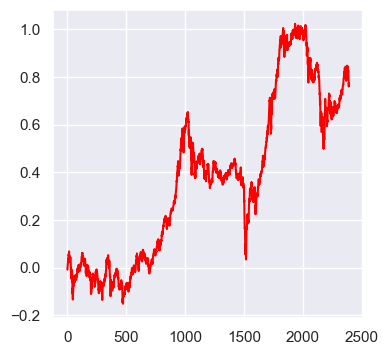

In [ ]:
plt.plot(data_svm['Cum_Ret'],color='red') 

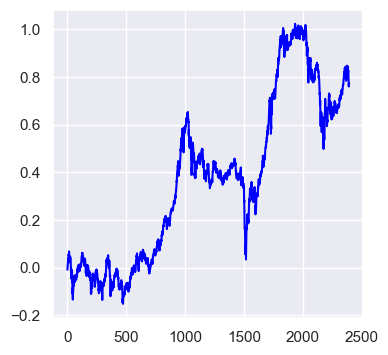

In [ ]:
plt.plot(data_svm['Cum_Strategy'],color='blue')

## LSTM

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred_lstm[i], y_test_lstm[i])

15/15 [==============================] - 1s 6ms/step
[1.6932234] [2.21247888]
[1.6628082] [2.20379445]
[1.6325825] [2.21642959]
[1.68095] [2.23031045]
[1.6742327] [2.19995052]
[1.6293192] [2.18806281]
[1.638839] [2.1544996]
[1.6454514] [2.20283346]
[1.6795225] [2.20546727]
[1.6290687] [2.1646789]


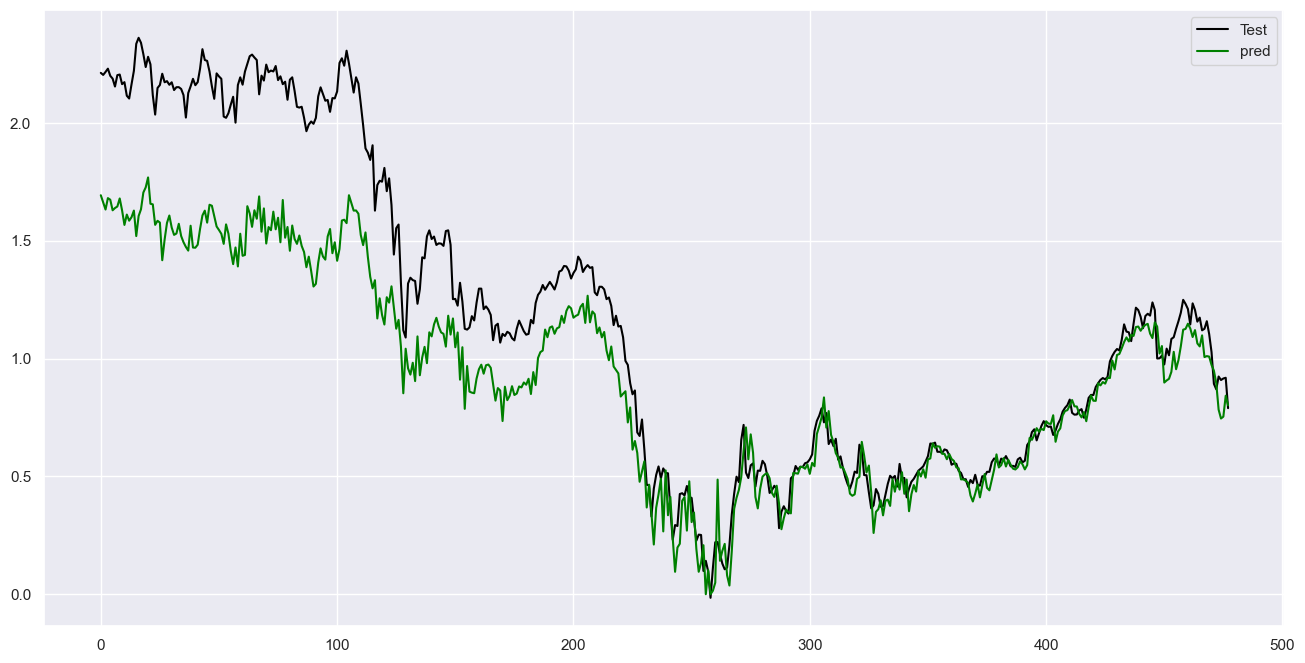

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_lstm, color = 'black', label = 'Test')
plt.plot(y_pred_lstm, color = 'green', label = 'pred')
plt.legend()
plt.show()

# 5. References
1. https://vnexpress.net/chi-bao-rsi-la-gi-4481781.html